**Modeling Pipeline - Long Term:**


# **Setting up environment**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup working directory
%cd /content/drive/My Drive/Colab Notebooks/FP2

/content/drive/My Drive/Colab Notebooks/FP2


In [ ]:
# # Create requirements file
%%writefile requirements.txt

mlflow
yfinance>=0.1.55
cvxpy>=1.2.2
matplotlib>=3.2.0
numpy>=1.12.0
pandas>=0.19
scikit-learn>=0.24.1
scipy>=1.3.0
pyfolio
backtrader[plotting]
yahoo_fin
pmdarima

Overwriting requirements.txt


In [ ]:
 !pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
!databricks configure --host https://community.cloud.databricks.com/

Username: teamgoutham@gmail.com
Password: 
Repeat for confirmation: 
Error: The two entered values do not match.
Password: 
Repeat for confirmation: 


In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
import plotly.express as px
from yahoo_fin.stock_info import get_data
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import mlflow.keras
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Check versions of libraries

print("Pandas Version:",format(pd.__version__))
print("MLFLOW Version:",format(mlflow.__version__))

Pandas Version: 1.5.3
MLFLOW Version: 2.9.1


In [ ]:
# Set up mlflow tracking
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/teamgoutham@gmail.com/FP2-AAPL-Forecast-Longterm-Model")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/444171490769122', creation_time=1701971534901, experiment_id='444171490769122', last_update_time=1701971847341, lifecycle_stage='active', name='/Users/teamgoutham@gmail.com/FP2-AAPL-Forecast-Longterm-Model', tags={'mlflow.experiment.sourceName': '/Users/teamgoutham@gmail.com/FP2-AAPL-Forecast-Longterm-Model',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'teamgoutham@gmail.com',
 'mlflow.ownerId': '4993308857315333'}>

# New Section

In [ ]:
# Setup database connection details
db_credentials = {
    'user': 'goutham',
    'password': 'SharpMinded',
    'host': 'my-term5-db-instance.cdcogaqzqvwg.us-east-1.rds.amazonaws.com',
    'database': 'term5_default_database'
}

# **Stock Data EDA**

In [ ]:
# Connection using psycopg2
conn = psycopg2.connect(**db_credentials)

monthly_table_name = 'monthly_data_aapl'

# Query to select all rows from the table
monthly_select_query = f"SELECT * FROM {monthly_table_name}"

# Using pandas read_sql to read data into a DataFrame
monthly_data_table = pd.read_sql(monthly_select_query, conn)

monthly_data = monthly_data_table.copy()

# Closing the connection
conn.close()

<ipython-input-10-2af4db4d05ce>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_data_table = pd.read_sql(monthly_select_query, conn)


In [ ]:
print("monthly rows imported: ", len(monthly_data))

monthly rows imported:  189


In [ ]:
# Drop NA
monthly_data.dropna(how='any',inplace=True)
print("monthly rows after dropping na: ", len(monthly_data))

monthly rows after dropping na:  189


In [ ]:
monthly_data.tail()

,date,open,high,low,close,adjclose,volume,ticker
184,2023-08-01,130.779999,138.000000,126.379997,136.169998,136.169998,593289000,GOOGL
185,2023-09-01,137.460007,139.160004,127.220001,130.860001,130.860001,477542100,GOOGL
186,2023-10-01,131.210007,141.220001,120.209999,124.080002,124.080002,680712800,GOOGL
187,2023-11-01,124.070000,139.419998,123.720001,132.529999,132.529999,535220300,GOOGL
188,2023-12-01,131.860001,132.139999,127.900002,130.020004,130.020004,119006600,GOOGL


In [ ]:
# Set list of pred columns

value_cols = ["date","close"]

In [ ]:
# reset index after dropping na
monthly_data.reset_index(inplace=True)
monthly_data = monthly_data[value_cols]
monthly_data.head()

,date,close
0,2008-04-01,14.371622
1,2008-05-01,14.659660
2,2008-06-01,13.173674
3,2008-07-01,11.855606
4,2008-08-01,11.593844


In [ ]:
#Normalize stock data based on initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [ ]:
#Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:

    fig.add_scatter(x = df['date'], y = df[i], name = i)
  fig.show()

In [ ]:
interactive_plot(monthly_data,'Monthly Prices')

In [ ]:
MMS = MinMaxScaler()


lstm_monthly_data = monthly_data.copy()

lstm_monthly_data.set_index('date',drop=True,inplace=True)
lstm_monthly_data[lstm_monthly_data.columns] = MMS.fit_transform(lstm_monthly_data)

In [ ]:
lstm_monthly_data.head()

,close
date,
2008-04-01,0.050032
2008-05-01,0.052079
2008-06-01,0.041519
2008-07-01,0.032152
2008-08-01,0.030292


In [ ]:
training_size = round(len(lstm_monthly_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

151

In [ ]:
train_data = lstm_monthly_data[:training_size]
test_data  = lstm_monthly_data[training_size:]

print("training data size:" , len(train_data))
print("testing data size:" , len(test_data))

training data size: 151
testing data size: 38


In [ ]:
 # Function to create sequence of data for training and testing

def create_sequence(dataset):
                sequences = []
                labels = []
                start_idx = 0
                for stop_idx in range(6,len(dataset)):                   # Selecting 6 rows at a time
                    sequences.append(dataset.iloc[start_idx:stop_idx])
                    labels.append(dataset.iloc[stop_idx])
                    start_idx += 1
                return (np.array(sequences),np.array(labels))

In [ ]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

test_shape_len = test_seq.shape[0]

# **LSTM**

In [ ]:
# Start mlflow run
with mlflow.start_run():
    # Define LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

    model.add(Dropout(0.1))
    model.add(LSTM(units=50))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    no_epochs = 200


    # Fit LSTM model
    model_lstm = model.fit(train_seq, train_label, epochs=no_epochs,validation_data=(test_seq, test_label), verbose=1)

    # mlflow.keras.log_model(model_lstm, "models")
    mlflow.tensorflow.autolog()

    # Make predictions on test set
    test_predicted = model.predict(test_seq)
    test_inverse_predicted = MMS.inverse_transform(test_predicted)

    # Inverse transform the actual test labels
    test_actual = MMS.inverse_transform(test_label)

    # Calculate MSE and MAE for LSTM
    mse_lstm = mean_squared_error(test_actual, test_inverse_predicted)
    mae_lstm = mean_absolute_error(test_actual, test_inverse_predicted)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("epochs", no_epochs)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("mse", mse_lstm)
    mlflow.log_metric("mae", mae_lstm)

    # Save model as artifact
    run_id = mlflow.active_run().info.run_id
    # mlflow.log_artifact("model_lstm.pkl")

Epoch 1/200
5/5 [==============================] - 5s 270ms/step - loss: 0.0378 - mean_absolute_error: 0.1483 - val_loss: 0.3550 - val_mean_absolute_error: 0.5853
Epoch 2/200
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0844

5/5 [==============================] - 0s 19ms/step - loss: 0.0154 - mean_absolute_error: 0.0933 - val_loss: 0.1446 - val_mean_absolute_error: 0.3646
Epoch 3/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0079 - mean_absolute_error: 0.0779 - val_loss: 0.0445 - val_mean_absolute_error: 0.1801
Epoch 4/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0077 - mean_absolute_error: 0.0753 - val_loss: 0.0493 - val_mean_absolute_error: 0.1929
Epoch 5/200
5/5 [==============================] - 0s 23ms/step - loss: 0.0044 - mean_absolute_error: 0.0569 - val_loss: 0.0652 - val_mean_absolute_error: 0.2307
Epoch 6/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0035 - mean_absolute_error: 0.0472 - val_loss: 0.0400 - val_mean_absolute_error: 0.1673
Epoch 7/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0020 - mean_absolute_error: 0.0352 - val_loss: 0.0167 - val_mean_absolute_error: 0.1122
Epoch 8/200
5/5 [=======================

Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2023/12/07 17:58:41 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 6, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

1/1 [==============================] - 0s 43ms/step


array([[0.66664505],
       [0.7057289 ],
       [0.7479352 ],
       [0.7967798 ],
       [0.84720397]], dtype=float32)

In [ ]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[101.13807 ],
       [106.63774 ],
       [112.57678 ],
       [119.449936],
       [126.54536 ]], dtype=float32)

In [ ]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([lstm_monthly_data.iloc[-test_shape_len:].copy(),pd.DataFrame(test_inverse_predicted,columns=['close_predicted'],index=lstm_monthly_data.iloc[-test_shape_len:].index)], axis=1)

In [ ]:
gs_slic_data[['close_unscaled']] = MMS.inverse_transform(gs_slic_data[['close']]) # Inverse scaling

In [ ]:
gs_slic_data.head()

,close,close_predicted,close_unscaled
date,,,
2021-05-01,0.785356,101.138069,117.842499
2021-06-01,0.815538,106.637741,122.089500
2021-07-01,0.905344,112.576782,134.726501
2021-08-01,0.976204,119.449936,144.697495
2021-09-01,0.897878,126.545357,133.675995


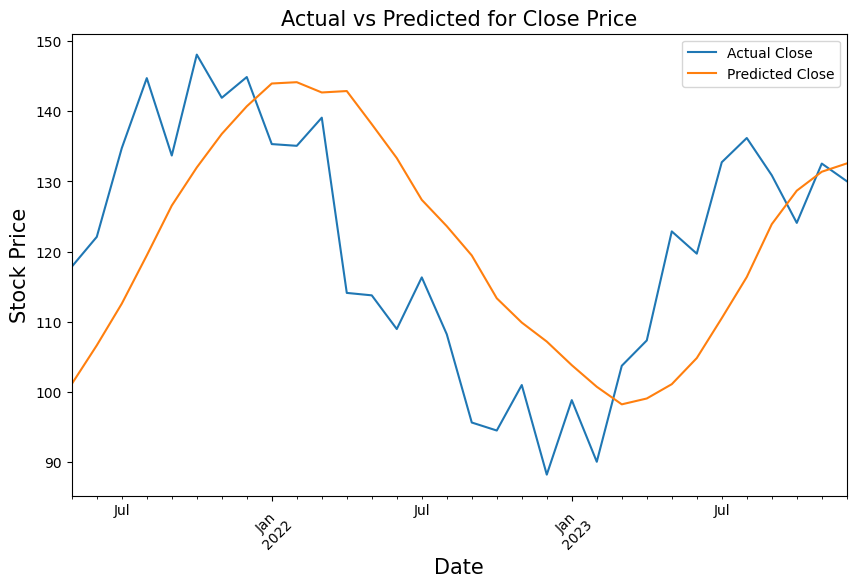

In [ ]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted Close Prices
gs_slic_data[['close_unscaled','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date', size=15)
plt.ylabel('Stock Price', size=15)
plt.title('Actual vs Predicted for Close Price', size=15)
plt.legend(['Actual Close', 'Predicted Close'])
plt.show()

In [ ]:
# Creating a dataframe and adding 4 months to existing index
gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=4, freq='D', closed='right')))

# gs_slic_data.tail(15)

<ipython-input-161-cfc77d5f2b40>:2: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

<ipython-input-161-cfc77d5f2b40>:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
upcoming_prediction = pd.DataFrame(columns=['close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [ ]:
curr_seq = test_seq[-1:]
for i in range(-4,0):
    up_pred = model.predict(curr_seq)
    upcoming_prediction.iloc[i] = up_pred
    curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
    curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 49ms/step


In [ ]:
upcoming_prediction[['close_unscaled']] = MMS.inverse_transform(upcoming_prediction[['close']])

In [ ]:
upcoming_prediction.tail(4)

,close,close_unscaled
2023-12-01,0.889853,132.546765
2023-12-02,0.901128,134.133213
2023-12-03,0.902755,134.362193
2023-12-04,0.902971,134.392639


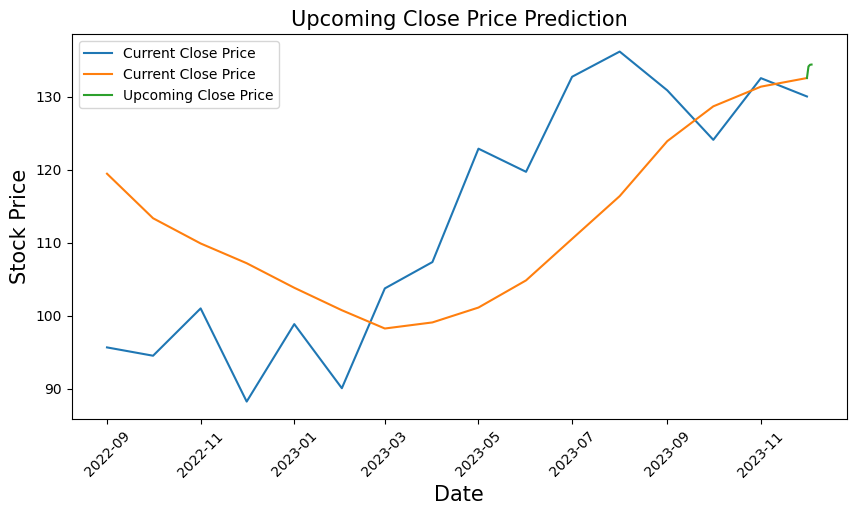

In [ ]:
# Plotting Upcoming Close Price Prediction
fg, ax = plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2022-09-01':, 'close_unscaled'], label='Current Close Price')
ax.plot(gs_slic_data.loc['2022-09-01':, 'close_predicted'], label='Current Close Price')
ax.plot(upcoming_prediction.loc['2022-09-01':, 'close_unscaled'], label='Upcoming Close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Stock Price', size=15)
ax.set_title('Upcoming Close Price Prediction', size=15)
ax.legend()
fg.show()

# ARIMA

In [ ]:
arima_monthly_data = monthly_data.copy()

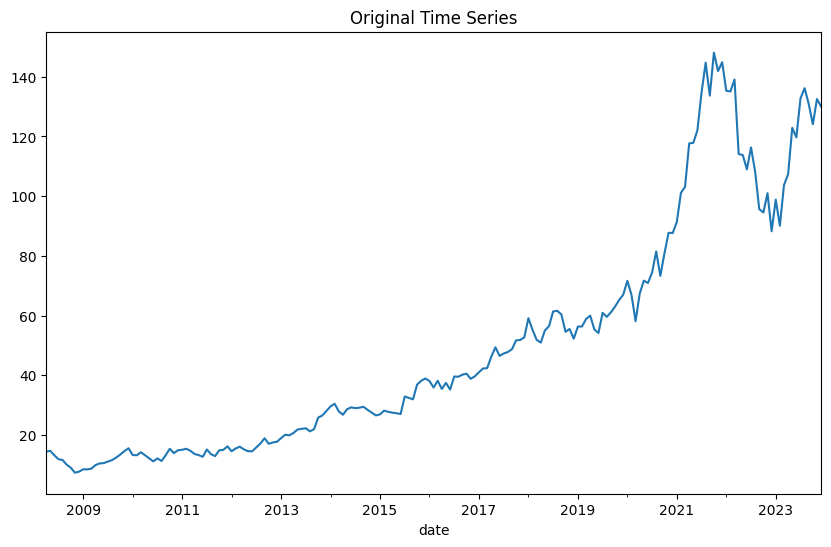

In [ ]:
arima_monthly_data.set_index('date', inplace=True)

# Plot the original time series
arima_monthly_data['close'].plot(figsize=(10, 6), title='Original Time Series')
plt.show()

In [ ]:
# Split data into training and testing sets (80% training, 20% testing)
training_size = round(len(arima_monthly_data) * 0.80)
train_data = arima_monthly_data[:training_size]
test_data = arima_monthly_data[training_size:]

train_close = train_data['close'].dropna()  # Ensure no NaN values
test_close = test_data['close'].dropna()

print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))

Training data size: 151
Testing data size: 38


In [ ]:
from pmdarima import auto_arima
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Start mlflow run for ARIMA model
with mlflow.start_run():
    # Find the best ARIMA model using auto_arima
    arima_model = auto_arima(train_close, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

    # Make predictions on test set
    arima_pred = arima_model.predict(n_periods=len(test_close))

    # Calculate mean squared error
    mse_arima = mean_squared_error(test_close, arima_pred)
    mae_arima = mean_absolute_error(test_close, arima_pred)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "ARIMA")
    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("mse", mse_arima)
    mlflow.log_metric("mape", mae_arima)

    # Save model as artifact
    mlflow.pmdarima.log_model(arima_model, "model")

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=823.368, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=781.586, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=821.392, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=747.665, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=738.278, Time=0.26 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=739.066, Time=0.30 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=736.339, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=745.699, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=737.138, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=698.923, Time=0.33 sec
 A

2023/12/07 17:54:08 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.9.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
arima_test_data = test_data.copy()

arima_pred = arima_pred.reset_index(drop=True)

arima_test_data.loc[:, "predictions"] = arima_pred.values

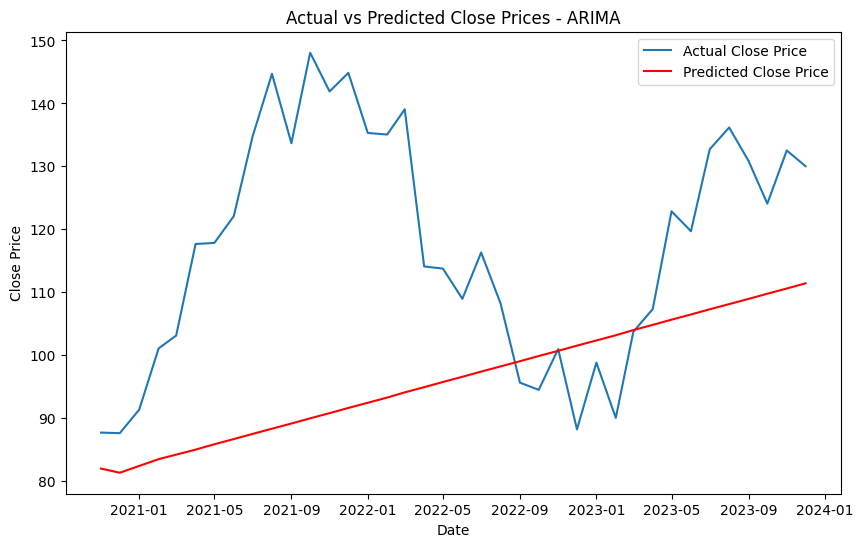

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(arima_test_data.index, arima_test_data.close, label='Actual Close Price')
plt.plot(arima_test_data.index, arima_test_data.predictions, label='Predicted Close Price', color='red')
plt.title("Actual vs Predicted Close Prices - ARIMA")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Start mlflow run
with mlflow.start_run():
    # Define SARIMA model
    model = SARIMAX(train_close, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

    # Fit SARIMA model
    model_fit = model.fit()

    # Make predictions on test set
    sarimax_test_pred = model_fit.forecast(len(test_close))

    # Calculate mean squared error
    mse = mean_squared_error(test_close, sarimax_test_pred)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "SARIMA")
    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("mse", mse)

    # Save model as artifact
    mlflow_SARIMA_file = "SARIMA_model.pkl"
    with open(mlflow_SARIMA_file, "wb") as f:
        pickle.dump(model, f)
    mlflow.log_artifact(mlflow_SARIMA_file, "model")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
sarimax_test_data = test_data.copy()

sarimax_pred = sarimax_test_pred.reset_index(drop=True)

sarimax_test_data.loc[:, "predictions"] = sarimax_pred.values

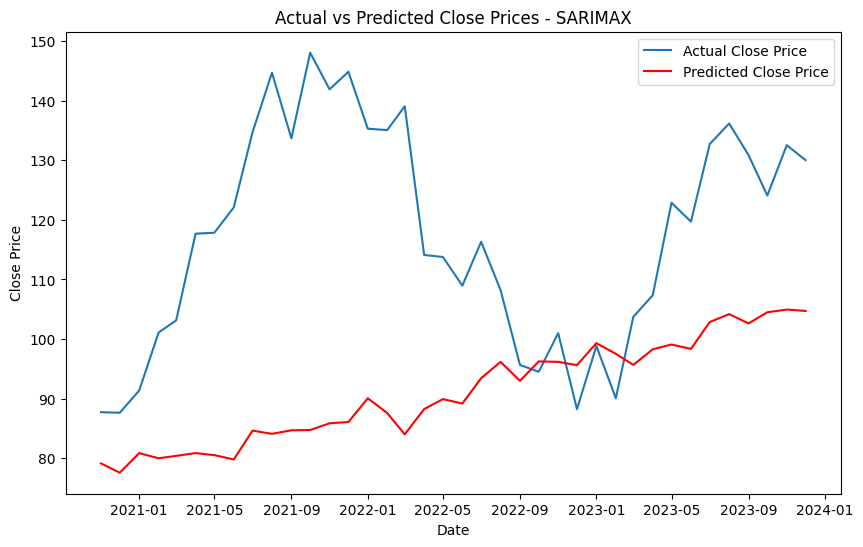

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(sarimax_test_data.index, sarimax_test_data.close, label='Actual Close Price')
plt.plot(sarimax_test_data.index, sarimax_test_data.predictions, label='Predicted Close Price', color='red')
plt.title("Actual vs Predicted Close Prices - SARIMAX")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Prophet

In [ ]:
from prophet import Prophet
import mlflow.pyfunc

In [ ]:
# Start mlflow run for Prophet model
with mlflow.start_run():
    # Prepare data for Prophet model
    prophet_data = pd.DataFrame({"ds": train_close.index, "y": train_close})

    # Train Prophet model
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)

    # Make predictions on test set
    future = prophet_model.make_future_dataframe(periods=len(test_close))
    forecast = prophet_model.predict(future)["yhat"][-len(test_close):]

    # Calculate mean squared error
    mse = mean_squared_error(test_close, forecast)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "Prophet")
    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("mse", mse)

    # Save model as artifact
    mlflow_Prophet_file = "Prophet_model.pkl"
    with open(mlflow_Prophet_file, "wb") as f:
        pickle.dump(prophet_model, f)
    mlflow.log_artifact(mlflow_Prophet_file, "model")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4b12vnol/zn25hgky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4b12vnol/dkll9ors.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81056', 'data', 'file=/tmp/tmp4b12vnol/zn25hgky.json', 'init=/tmp/tmp4b12vnol/dkll9ors.json', 'output', 'file=/tmp/tmp4b12vnol/prophet_model94btdqf4/prophet_model-20231207175419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
prophet_test_data = test_data.copy()

forecast = forecast.reset_index(drop=True)
prophet_test_data.loc[:, "predictions"] = forecast.values

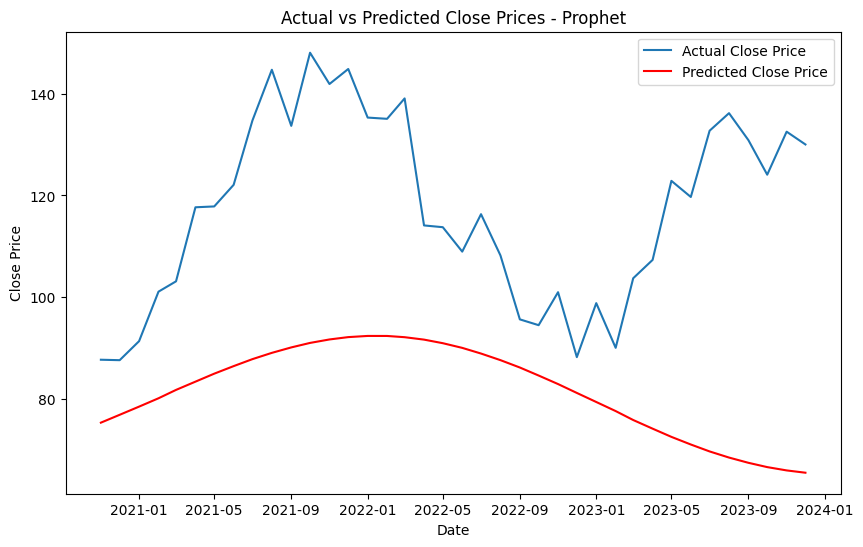

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(prophet_test_data.index, prophet_test_data.close, label='Actual Close Price')
plt.plot(prophet_test_data.index, prophet_test_data.predictions, label='Predicted Close Price', color='red')
plt.title("Actual vs Predicted Close Prices - Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Run the Best Model


In [ ]:
full_data_seq, full_data_label = create_sequence(lstm_monthly_data)

full_data_shape_len = full_data_seq.shape[0]

In [ ]:
# Start mlflow run
with mlflow.start_run(run_name='Best_Long_Term_LSTM_Model'):
    # Define LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape = (full_data_seq.shape[1], full_data_seq.shape[2])))

    model.add(Dropout(0.1))
    model.add(LSTM(units=50))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    no_epochs = 200


    # Fit LSTM model
    model_lstm = model.fit(full_data_seq, full_data_label, epochs=no_epochs,validation_data=(test_seq, test_label), verbose=1)

    # mlflow.keras.log_model(model_lstm, "models")
    mlflow.tensorflow.autolog()

    # Make predictions on test set
    test_predicted = model.predict(test_seq)
    test_inverse_predicted = MMS.inverse_transform(test_predicted)

    # Inverse transform the actual test labels
    test_actual = MMS.inverse_transform(test_label)

    # Calculate MSE and MAE for LSTM
    mse_lstm = mean_squared_error(test_actual, test_inverse_predicted)
    mae_lstm = mean_absolute_error(test_actual, test_inverse_predicted)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("epochs", no_epochs)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("mse", mse_lstm)
    mlflow.log_metric("mae", mae_lstm)

    # Save model as artifact
    run_id = mlflow.active_run().info.run_id
    # mlflow.log_artifact("model_lstm.pkl")

Epoch 1/200
4/6 [===================>..........] - ETA: 0s - loss: 0.1789 - mean_absolute_error: 0.3154 

6/6 [==============================] - 10s 330ms/step - loss: 0.1480 - mean_absolute_error: 0.2730 - val_loss: 0.3743 - val_mean_absolute_error: 0.6011
Epoch 2/200
6/6 [==============================] - 0s 30ms/step - loss: 0.0640 - mean_absolute_error: 0.1720 - val_loss: 0.1140 - val_mean_absolute_error: 0.3188
Epoch 3/200
6/6 [==============================] - 0s 29ms/step - loss: 0.0218 - mean_absolute_error: 0.1244 - val_loss: 0.0149 - val_mean_absolute_error: 0.1048
Epoch 4/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0229 - mean_absolute_error: 0.1419 - val_loss: 0.0148 - val_mean_absolute_error: 0.1051
Epoch 5/200
6/6 [==============================] - 0s 31ms/step - loss: 0.0108 - mean_absolute_error: 0.0903 - val_loss: 0.0320 - val_mean_absolute_error: 0.1492
Epoch 6/200
6/6 [==============================] - 0s 29ms/step - loss: 0.0096 - mean_absolute_error: 0.0705 - val_loss: 0.0264 - val_mean_absolute_error: 0.1354
Epoch 7/200
6/6 [=====================

Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2023/12/08 17:04:09 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
